# Code Block 1

In [1]:
############################ Load required libraries ############################
import torch
!pip install torchsummary
from torchsummary import summary
import matplotlib.pyplot as plt


# Load Model configuration
from models import Modelx
# Load necessary functions
from utils import  *



################################ Hyperparamters ################################




# variables to store data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Define hyperparameters
batch_size = 128          # Define the batch size for data loading
lr = 0.04                 # Define learning rate value
momentum = 0.9            # Define momentum value
step_size= 6              # Define stepsize value in scheduler
gamma=0.1                 # Define dacay value of learning rate in scheduler

criterion_name = "nll_loss"       # Define criterion name
num_epochs = 20                   # Number of epochs for training
optimizer_algo = "SGD"            # Define optimizer name
normtype = "gn"                   # gn/ln/bn for type of normalization
dropout_num = 0.05

# Create a dictionary of keyword arguments (kwargs) for DataLoader
kwargs = {
    'batch_size': batch_size,   # Set the batch size for each batch of data
    'shuffle': True,            # ensures that the model encounters a diverse mix of data during training, leading to better learning and generalization (during testing, the order of data doesn’t impact the model’s predictions)
    'num_workers': 4,           # Number of worker threads for data loading ( each worker will deal with batchsize/num_workers set of data under a batch) # parallel processing-> reduces overall time
    'pin_memory': True          # Enable pinning memory for faster GPU transfer
}


# Code Block 2

In [2]:
# check if CUDA is available or not
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")       #setting the device on which computations will be executed
print("Device set to: ",device)

CUDA Available? True
Device set to:  cuda


# Code Block 3

In [3]:
## Get CIFAR dataset and pass it to loader

_ ,test_loader            = get_CIFARdataset_with_loader('test',kwargs)   # load test data
label_, train_loader      = get_CIFARdataset_with_loader('train',kwargs)  # load train data
print()

label_map = {v: k for k, v in label_.items()}
label_map

Files already downloaded and verified
Testing data loaded successfully. Shape of data:  (10000, 32, 32, 3)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Training data loaded successfully. Shape of data:  (50000, 32, 32, 3)



{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [4]:
# check shape
checkdata, checklabel  = next(iter(train_loader))
checkdata.shape

torch.Size([128, 3, 32, 32])

# Code Block 4

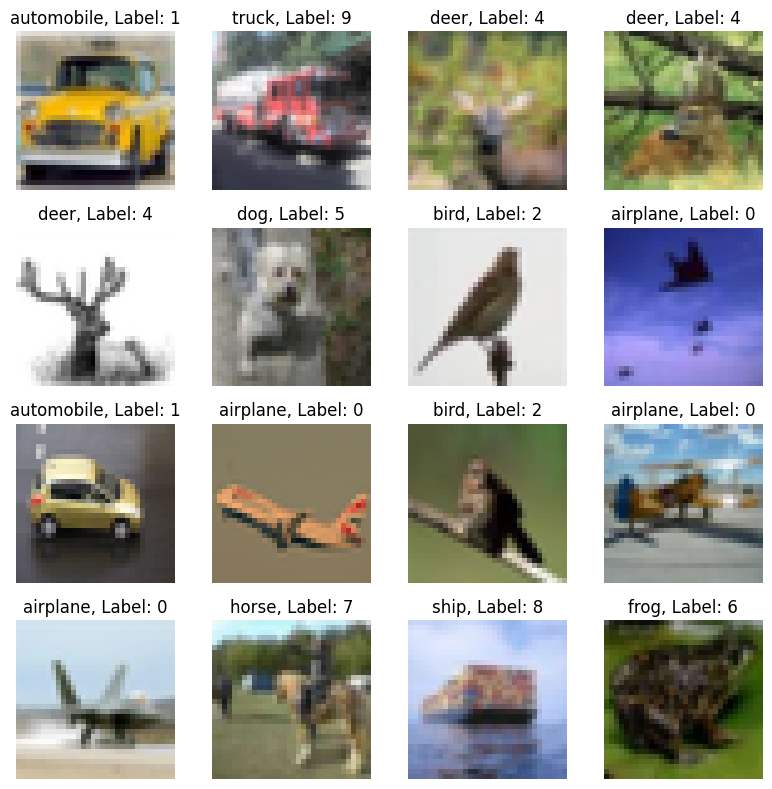

In [5]:
################ Display a sample of data from the training dataset #####################
post_display(train_loader,label_map)

# Code Block 5

In [6]:
# Set seed
torch.manual_seed(1)

# Initialize the model and move it to the device ( GPU )
model = Modelx(dropout_value = dropout_num, norm_form = normtype, num_group=4).to(device)

#Get summary of model
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
              ReLU-2           [-1, 16, 30, 30]               0
         GroupNorm-3           [-1, 16, 30, 30]              32
            Conv2d-4           [-1, 32, 28, 28]           4,608
              ReLU-5           [-1, 32, 28, 28]               0
         GroupNorm-6           [-1, 32, 28, 28]              64
           Dropout-7           [-1, 32, 28, 28]               0
            Conv2d-8           [-1, 16, 28, 28]             512
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 24, 14, 14]           3,456
             ReLU-11           [-1, 24, 14, 14]               0
        GroupNorm-12           [-1, 24, 14, 14]              48
          Dropout-13           [-1, 24, 14, 14]               0
           Conv2d-14           [-1, 32,

# Code Block 6

In [7]:
####################################################### Train Model#####################################################

# Set up the optimizer with stochastic gradient descent with learning rate and momentum
optimizer = get_optimizer(model,optimizer_algo, lr, momentum)

# Configure a learning rate scheduler that decays the learning rate by a factor of 0.1 every 15 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Define the loss function as negative log likelihood loss.
criterion = get_loss(criterion_name)


print(f"The current learning rate is: {[lr]}")
# Loop over the dataset multiple times, once for each epoch
for epoch in range(1, num_epochs+1):
  # Print the current epoch number
  print(f'Epoch {epoch}')

  # Call the train function, passing in the model, device, data loader, optimizer, and loss function
  train(model, device, train_loader, optimizer, criterion,train_losses,train_acc)

  # After training, evaluate the model on the same training data loader (should be test_loader for evaluation)
  misclassified_samples = test(model, device, test_loader, criterion,test_losses,test_acc)

  scheduler.step()   #update the lr
  current_lr = scheduler.get_last_lr()  # Get the latest learning rate
  print(f"The current learning rate is: {current_lr}")


The current learning rate is: [0.04]
Epoch 1


Train: Loss=1.3597 Batch_id=390 Accuracy=38.51: 100%|██████████| 391/391 [00:24<00:00, 16.22it/s]


Test set: Average loss: 0.0112, Accuracy: 4843/10000 (48.43%)

The current learning rate is: [0.04]
Epoch 2


Train: Loss=1.1112 Batch_id=390 Accuracy=53.37: 100%|██████████| 391/391 [00:19<00:00, 19.82it/s]


Test set: Average loss: 0.0092, Accuracy: 5843/10000 (58.43%)

The current learning rate is: [0.04]
Epoch 3


Train: Loss=1.0479 Batch_id=390 Accuracy=61.82: 100%|██████████| 391/391 [00:19<00:00, 19.89it/s]


Test set: Average loss: 0.0080, Accuracy: 6453/10000 (64.53%)

The current learning rate is: [0.04]
Epoch 4


Train: Loss=0.9138 Batch_id=390 Accuracy=67.01: 100%|██████████| 391/391 [00:19<00:00, 19.58it/s]


Test set: Average loss: 0.0070, Accuracy: 6924/10000 (69.24%)

The current learning rate is: [0.04]
Epoch 5


Train: Loss=0.8416 Batch_id=390 Accuracy=70.28: 100%|██████████| 391/391 [00:21<00:00, 18.59it/s]


Test set: Average loss: 0.0069, Accuracy: 7002/10000 (70.02%)

The current learning rate is: [0.04]
Epoch 6


Train: Loss=0.9980 Batch_id=390 Accuracy=72.51: 100%|██████████| 391/391 [00:20<00:00, 18.97it/s]


Test set: Average loss: 0.0060, Accuracy: 7417/10000 (74.17%)

The current learning rate is: [0.004]
Epoch 7


Train: Loss=0.6652 Batch_id=390 Accuracy=77.30: 100%|██████████| 391/391 [00:19<00:00, 19.82it/s]


Test set: Average loss: 0.0053, Accuracy: 7617/10000 (76.17%)

The current learning rate is: [0.004]
Epoch 8


Train: Loss=0.4713 Batch_id=390 Accuracy=77.89: 100%|██████████| 391/391 [00:19<00:00, 19.99it/s]


Test set: Average loss: 0.0053, Accuracy: 7675/10000 (76.75%)

The current learning rate is: [0.004]
Epoch 9


Train: Loss=0.6951 Batch_id=390 Accuracy=78.44: 100%|██████████| 391/391 [00:20<00:00, 18.73it/s]


Test set: Average loss: 0.0053, Accuracy: 7680/10000 (76.80%)

The current learning rate is: [0.004]
Epoch 10


Train: Loss=0.6194 Batch_id=390 Accuracy=78.55: 100%|██████████| 391/391 [00:20<00:00, 18.98it/s]


Test set: Average loss: 0.0052, Accuracy: 7729/10000 (77.29%)

The current learning rate is: [0.004]
Epoch 11


Train: Loss=0.5687 Batch_id=390 Accuracy=78.83: 100%|██████████| 391/391 [00:19<00:00, 19.83it/s]


Test set: Average loss: 0.0052, Accuracy: 7710/10000 (77.10%)

The current learning rate is: [0.004]
Epoch 12


Train: Loss=0.6662 Batch_id=390 Accuracy=79.28: 100%|██████████| 391/391 [00:19<00:00, 19.72it/s]


Test set: Average loss: 0.0051, Accuracy: 7755/10000 (77.55%)

The current learning rate is: [0.0004]
Epoch 13


Train: Loss=0.4873 Batch_id=390 Accuracy=79.89: 100%|██████████| 391/391 [00:20<00:00, 18.70it/s]


Test set: Average loss: 0.0051, Accuracy: 7783/10000 (77.83%)

The current learning rate is: [0.0004]
Epoch 14


Train: Loss=0.4859 Batch_id=390 Accuracy=79.94: 100%|██████████| 391/391 [00:20<00:00, 19.26it/s]


Test set: Average loss: 0.0050, Accuracy: 7795/10000 (77.95%)

The current learning rate is: [0.0004]
Epoch 15


Train: Loss=0.5378 Batch_id=390 Accuracy=80.07: 100%|██████████| 391/391 [00:19<00:00, 19.79it/s]


Test set: Average loss: 0.0051, Accuracy: 7788/10000 (77.88%)

The current learning rate is: [0.0004]
Epoch 16


Train: Loss=0.5671 Batch_id=390 Accuracy=79.85: 100%|██████████| 391/391 [00:20<00:00, 19.35it/s]


Test set: Average loss: 0.0051, Accuracy: 7774/10000 (77.74%)

The current learning rate is: [0.0004]
Epoch 17


Train: Loss=0.4839 Batch_id=390 Accuracy=79.94: 100%|██████████| 391/391 [00:20<00:00, 18.86it/s]


Test set: Average loss: 0.0051, Accuracy: 7784/10000 (77.84%)

The current learning rate is: [0.0004]
Epoch 18


Train: Loss=0.6648 Batch_id=390 Accuracy=80.17: 100%|██████████| 391/391 [00:20<00:00, 19.12it/s]


Test set: Average loss: 0.0050, Accuracy: 7787/10000 (77.87%)

The current learning rate is: [4e-05]
Epoch 19


Train: Loss=0.6053 Batch_id=390 Accuracy=80.33: 100%|██████████| 391/391 [00:19<00:00, 19.99it/s]


Test set: Average loss: 0.0051, Accuracy: 7786/10000 (77.86%)

The current learning rate is: [4e-05]
Epoch 20


Train: Loss=0.6137 Batch_id=390 Accuracy=80.30: 100%|██████████| 391/391 [00:19<00:00, 20.02it/s]


Test set: Average loss: 0.0051, Accuracy: 7788/10000 (77.88%)

The current learning rate is: [4e-05]


# Code Block 7

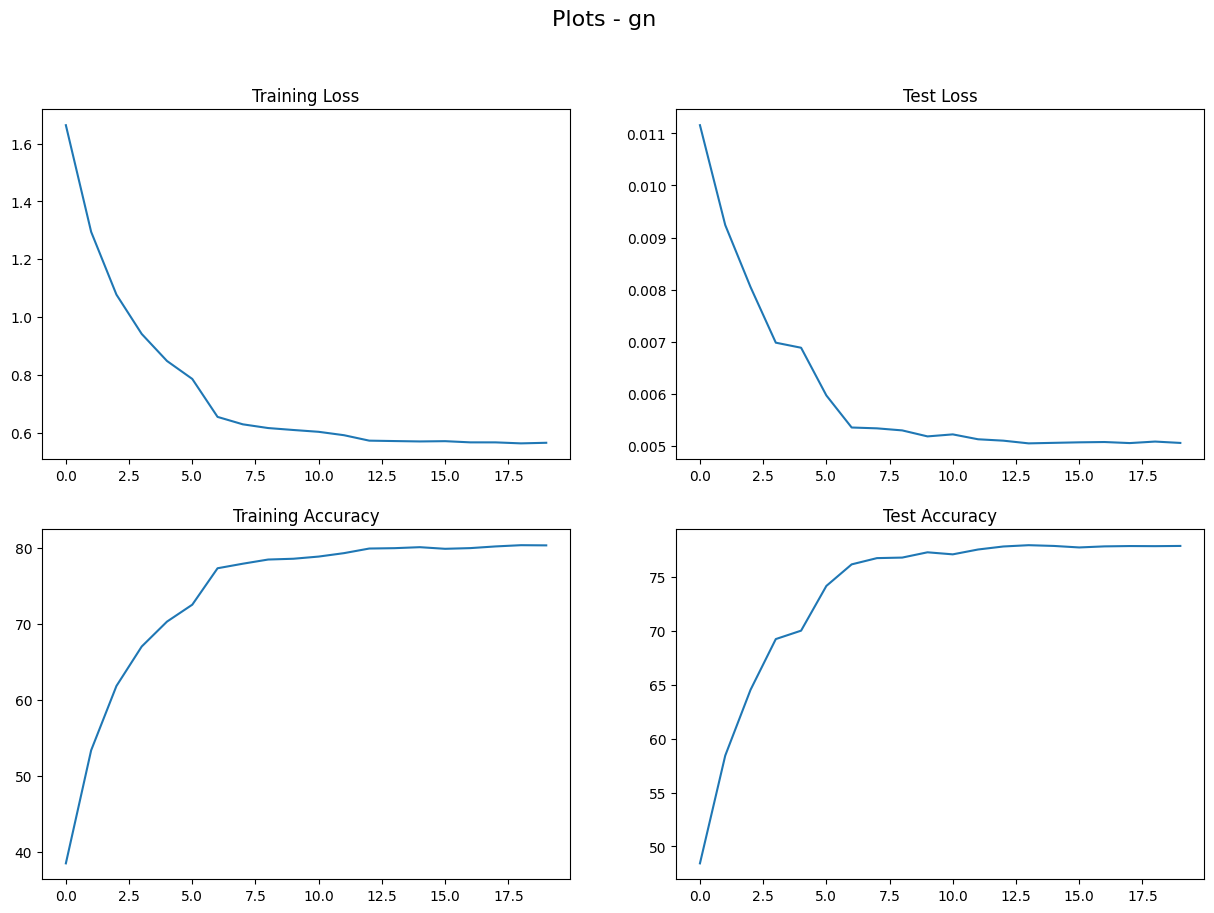

In [8]:
post_accuracyplots(train_losses,test_losses,train_acc,test_acc,normtype)

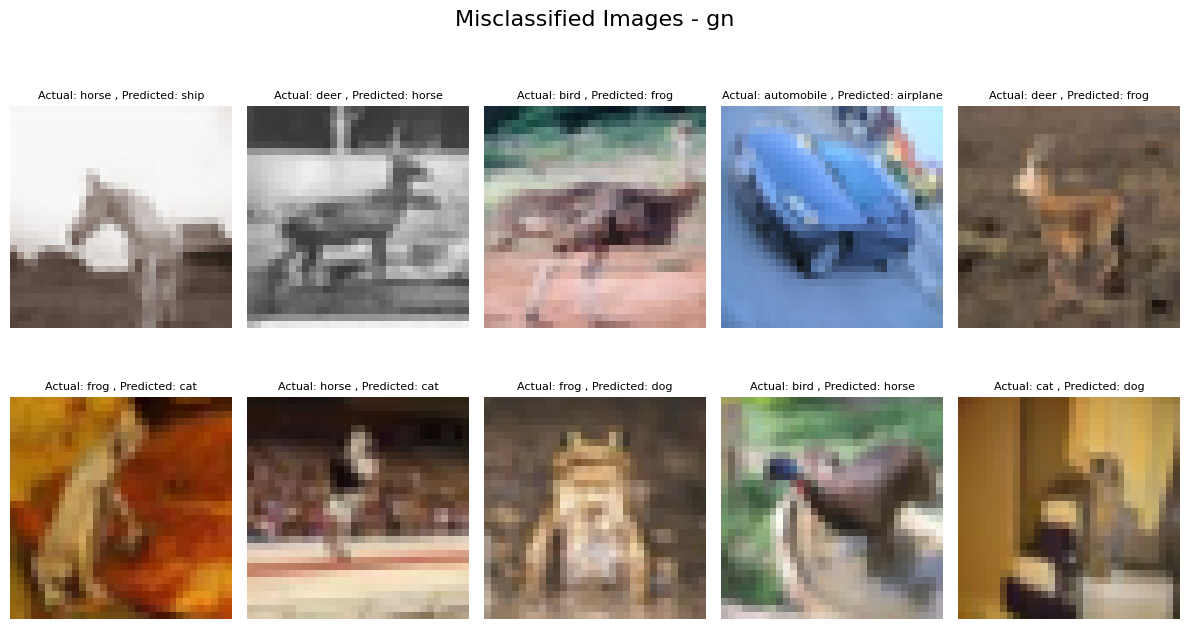

In [9]:
# Show misclassified samples from validation data
showmisclassifiedsamples(misclassified_samples,label_map,normtype)